<a href="https://colab.research.google.com/github/sayan0506/Anomaly-Detection-Using-LSTM-autoencoder/blob/main/Anomaly_Detection_Time_Series_Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


<h2 align=center>Introduction to Anomaly Detection in Time Series with Keras</h2>


## Task 1: Project Overview and Import Libraries

In [25]:
import numpy as np
import tensorflow as tf
import pandas as pd
pd.options.mode.chained_assignment = None
# seaborn is a visualization library
import seaborn as sns
from matplotlib.pylab import rcParams
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

%matplotlib inline

sns.set(style='whitegrid', palette='muted')
rcParams['figure.figsize'] = 14, 8
np.random.seed(1)
tf.random.set_seed(1)

print('Tensorflow version:', tf.__version__)

Tensorflow version: 2.4.0


## Task 2: Load and Inspect the S&P 500 Index Data

[Data Source](https://www.kaggle.com/pdquant/sp500-daily-19862018): S&P500 Daily Prices 1986 - 2018

In [26]:
# mounting the google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [27]:
df = pd.read_csv('/content/drive/MyDrive/Anomaly/S&P_500_Index_Data.csv', parse_dates=['date'])
# the dataset contains two columns, col1: Date, col2: Closing Price for S and P for those 1986-2018 year
df.head()

,date,close
0,1986-01-02,209.59
1,1986-01-03,210.88
2,1986-01-06,210.65
3,1986-01-07,213.80
4,1986-01-08,207.97


In [28]:
# shape of the dataset
df.shape

(8192, 2)

In [29]:
# GO stands for Graph Object
# fig is of go.Figure() type
fig = go.Figure()
# here we are adding trace to the scatter plot, thus, isdie the add trace we pass the function go.scatter, where we want to add trace
# It helps to better visualize the point after detecting the anomaly
# go.scatter takes x, y, mode and name = 'close', which is the plot name
fig.add_trace(go.Scatter(x=df.date, y=df.close,
                    mode='lines',
                    name='close'))
# fig.update_layout shows the legned is True, which returns the Plot name
fig.update_layout(showlegend=True)
fig.show()

## Task 3: Data Preprocessing

In [30]:
# Here we are splitting the data, where train_data is 80%
train_size = int(len(df) * 0.8)
test_size = len(df) - train_size
# train_test split is done here
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print(train.shape, test.shape)

(6553, 2) (1639, 2)


In [31]:
# Normalizing the data
from sklearn.preprocessing import StandardScaler

# standard scaewl object
scaler = StandardScaler()
# scaler.fit fits the train['close'] column datapoints to normalize, which converts the distribution where, mean = 0, std = 1, N~(0,1)
scaler = scaler.fit(train[['close']])

# transforms the 'close' prices to normalized one
train['close'] = scaler.transform(train[['close']])
test['close'] = scaler.transform(test[['close']])

## Task 4: Create Training and Test Splits

Convert input data into 3-D array combining TIME_STEPS. The shape of the array should be [samples, TIME_STEPS, features], as required for LSTM network.

In [32]:
# here we are crearing windowed dataset, we can also make this using the tf dataset modules
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        # appending the input window
        Xs.append(v)        
        # forecasted or reconstructed timestep is the timestep next to the window
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [53]:
# window_size
time_steps = 30

# training dataset
X_train, y_train = create_dataset(train[['close']], train.close, time_steps)
# testing dataset, y is the forecasted output after each of the time window
X_test, y_test = create_dataset(test[['close']], test.close, time_steps)

# returns the value contained in the column named 'close' as a a series
# Series is a one-dimensional labeled array capable of holding data of any type (integer, string, float, python objects, etc.). The axis labels are collectively called index.
print(type(train.close))
# returns the column as a dataframe
print(type(train[['close']]))
print(X_train.shape)
print(y_train.shape)

<class 'pandas.core.series.Series'>
<class 'pandas.core.frame.DataFrame'>
(6523, 30, 1)
(6523,)


## Task 5a: Build an LSTM Autoencoder

In [34]:
timesteps = X_train.shape[1]
# number of features = 1, i.e univariant timeseries
num_features = X_train.shape[2]

In [94]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, RepeatVector, TimeDistributed

# the model actually takes the time series window, and also returns or say reconstruct the forecast
# like 1000 datapoints having window size 10, then 0 to 970 datapoints or 970 windows are there
# 
model = Sequential([
                    # 1st LSTM layer having 128 nodes
    LSTM(128, input_shape=(timesteps, num_features)),
    Dropout(0.2),
    # RepeatVector acts as the brifdge between encoer and decoder part, which repeats single dimesnional output from LSTM to 30times here
    # which helps to acts as an input to the 1st LSTM decoder layer 
    RepeatVector(timesteps),
    LSTM(128, return_sequences=True),
    Dropout(0.2),
    # output from decoder LSTM is (30, 128)
    # we want (30,1) as reconstriucted sequence
    # so, Dense(1) creates single neuron of regression function(shape= (128,1)), TimeDistributed repeats that for 30 times or equals to the number of output sequence  
    # thus, matrix multiplication of (30, 128) and (128, 1) is (30, 1), so that the Dense layer is available toa ll timesteps corresponding to the time window
    # after the sequence getting reconstructed, we pass it to the Dense Layer which returns the single forecasted output
    TimeDistributed(Dense(num_features))                 
])

model.compile(loss='mae', optimizer='adam')
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (None, 128)               66560     
_________________________________________________________________
dropout_8 (Dropout)          (None, 128)               0         
_________________________________________________________________
repeat_vector_3 (RepeatVecto (None, 30, 128)           0         
_________________________________________________________________
lstm_13 (LSTM)               (None, 30, 128)           131584    
_________________________________________________________________
dropout_9 (Dropout)          (None, 30, 128)           0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, 30, 1)             129       
Total params: 198,273
Trainable params: 198,273
Non-trainable params: 0
________________________________________________

## Task 5b: Build an Normal LSTM Network, where there is no concept of Latent space

In [61]:
# define model
model1 = Sequential()
model1.add(LSTM(128, activation='relu', input_shape=(timesteps,num_features), return_sequences=True))
Dropout(0.2)
#model1.add(LSTM(64, activation='relu', return_sequences=True))
#model1.add(LSTM(64, activation='relu', return_sequences=True))
model1.add(LSTM(128, activation='relu', return_sequences=True))
Dropout(0.2)
model1.add(TimeDistributed(Dense(num_features)))
model1.compile(optimizer='adam', loss='mse')
model1.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 30, 128)           66560     
_________________________________________________________________
lstm_9 (LSTM)                (None, 30, 128)           131584    
_________________________________________________________________
time_distributed_3 (TimeDist (None, 30, 1)             129       
Total params: 198,273
Trainable params: 198,273
Non-trainable params: 0
_________________________________________________________________


## Task 6a: Train the Autoencoder

In [36]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, mode='min')
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    # among the X_train 10% is used for validation
    validation_split=0.1,
    callbacks = [es],
    shuffle=False
)

Epoch 1/100
184/184 [==============================] - 4s 10ms/step - loss: 0.2801 - val_loss: 0.1764
Epoch 2/100
184/184 [==============================] - 1s 6ms/step - loss: 0.1804 - val_loss: 0.0569
Epoch 3/100
184/184 [==============================] - 1s 6ms/step - loss: 0.1255 - val_loss: 0.0510
Epoch 4/100
184/184 [==============================] - 1s 6ms/step - loss: 0.1135 - val_loss: 0.0539
Epoch 5/100
184/184 [==============================] - 1s 6ms/step - loss: 0.1066 - val_loss: 0.0447
Epoch 6/100
184/184 [==============================] - 1s 6ms/step - loss: 0.1106 - val_loss: 0.0468
Epoch 7/100
184/184 [==============================] - 1s 6ms/step - loss: 0.1152 - val_loss: 0.0790
Epoch 8/100
184/184 [==============================] - 1s 6ms/step - loss: 0.1124 - val_loss: 0.0389
Epoch 9/100
184/184 [==============================] - 1s 6ms/step - loss: 0.1077 - val_loss: 0.0282
Epoch 10/100
184/184 [==============================] - 1s 6ms/step - loss: 0.1036 - val_l

## Task 7a: Plot Metrics and Evaluate the Model

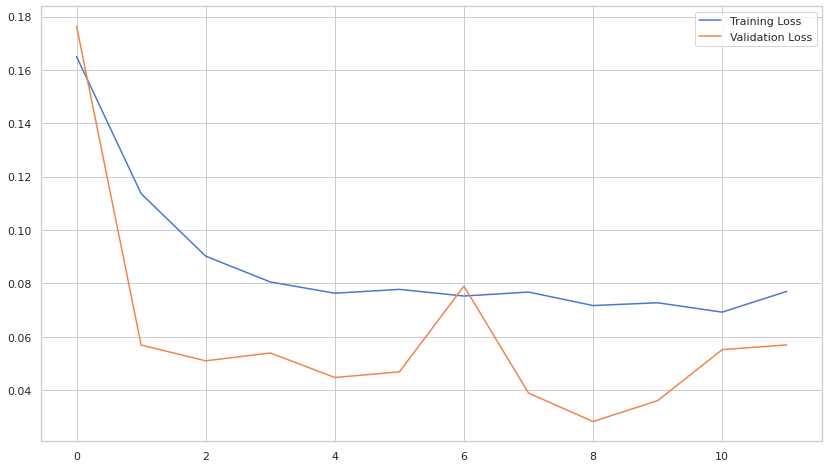

In [47]:
# training history visualization
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend();

## Task 6b: Train the Normal LSTM network

In [62]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, mode='min')
history1 = model1.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    # among the X_train 10% is used for validation
    validation_split=0.1,
    callbacks = [es],
    shuffle=False
)

Epoch 1/100
184/184 [==============================] - 17s 86ms/step - loss: 0.4436 - val_loss: 0.0740
Epoch 2/100
184/184 [==============================] - 15s 82ms/step - loss: 0.3428 - val_loss: 0.0558
Epoch 3/100
184/184 [==============================] - 15s 83ms/step - loss: 0.1272 - val_loss: 0.0360
Epoch 4/100
184/184 [==============================] - 16s 85ms/step - loss: 0.1427 - val_loss: 0.0381
Epoch 5/100
184/184 [==============================] - 15s 83ms/step - loss: 0.0874 - val_loss: 0.0238
Epoch 6/100
184/184 [==============================] - 15s 84ms/step - loss: 0.0667 - val_loss: 0.0342
Epoch 7/100
184/184 [==============================] - 15s 83ms/step - loss: 0.0574 - val_loss: 0.0319
Epoch 8/100
184/184 [==============================] - 15s 84ms/step - loss: 0.0466 - val_loss: 0.0464


## Task 7b: Plot Metrics and Evaluate the LSTM Model

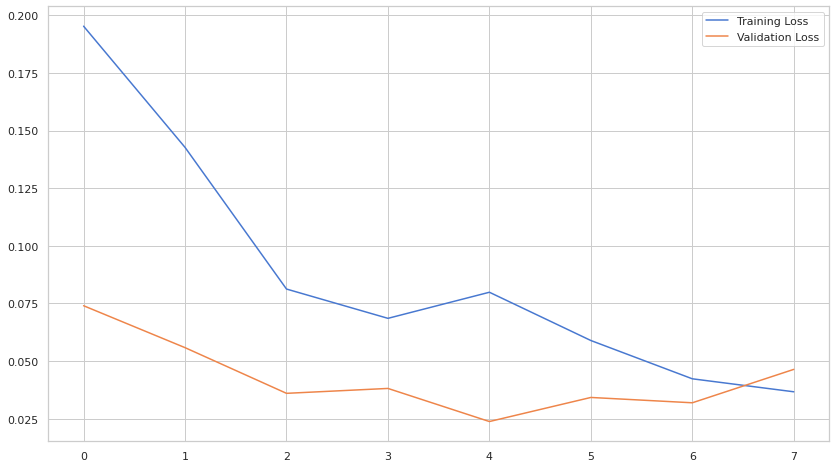

In [64]:
# training history visualization
plt.plot(history1.history['loss'], label='Training Loss')
plt.plot(history1.history['val_loss'], label='Validation Loss')
plt.legend();

In [65]:
X_train_pred_AE = model.predict(X_train)
X_train_pred_LSTM = model1.predict(X_train)

# calculating the mean_absolute error of prediction for LSTM AE
train_mae_loss_AE = pd.DataFrame(np.mean(np.abs(X_train_pred_AE - X_train), axis=1), columns=['Error'])
# calculating the mean_absolute error of prediction for LSTM 
train_mae_loss_LSTM = pd.DataFrame(np.mean(np.abs(X_train_pred_LSTM - X_train), axis=1), columns=['Error'])

In [66]:
# evaluating the test data for LSTM AE
model.evaluate(X_test, y_test)

51/51 [==============================] - 0s 3ms/step - loss: 0.3665


0.36646005511283875

In [67]:
# evaluating the test data for LSTM
model1.evaluate(X_test, y_test)

51/51 [==============================] - 0s 8ms/step - loss: 1.4313


1.4313220977783203

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



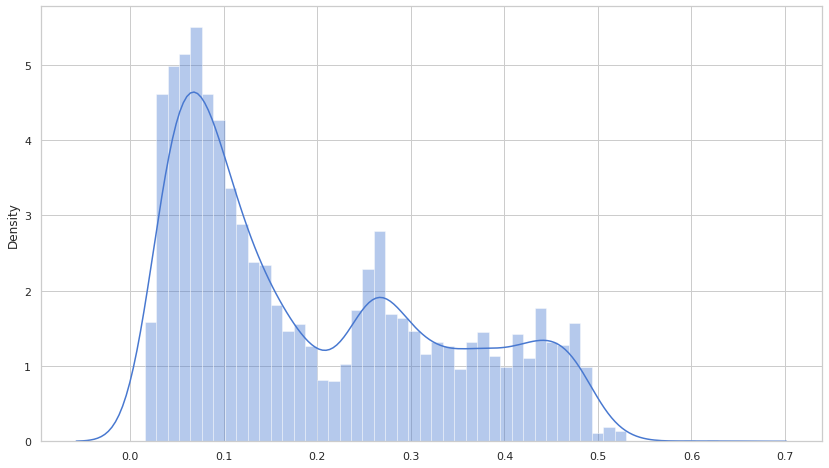

In [68]:
# error distribution for LSTM AE
sns.distplot(train_mae_loss_AE, bins=50, kde=True);

## From the plot of Training MAE distribution we can say, all the dtapoints MAE lie within 0.0 to 0.6
# so, we can consider threshold error or MAE around 0.60 or greater, let us say 0.65 for this

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



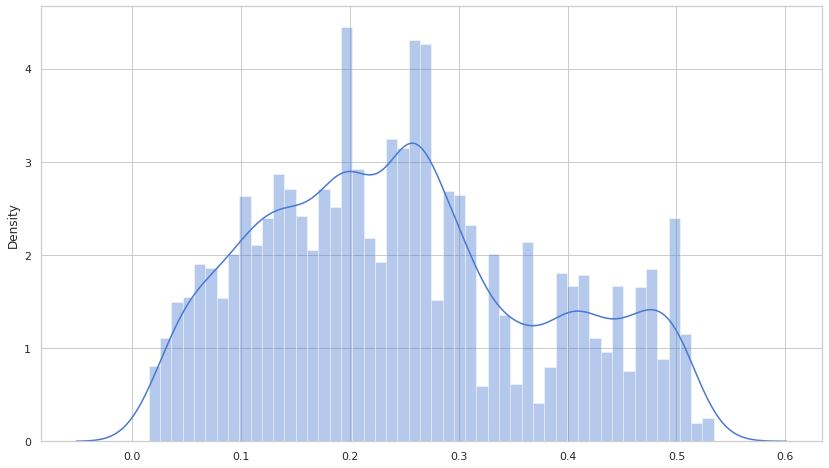

In [69]:
# error distribution for LSTM Network
sns.distplot(train_mae_loss_LSTM, bins=50, kde=True);

In [70]:
X_test_pred_AE = model.predict(X_test)

# distribution of the MAE loss for test data using AE
test_mae_loss_AE = np.mean(np.abs(X_test_pred_AE - X_test), axis=1)

In [71]:
X_test_pred_LSTM = model1.predict(X_test)

# distribution of the MAE loss for test data using AE
test_mae_loss_LSTM = np.mean(np.abs(X_test_pred_LSTM - X_test), axis=1)

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



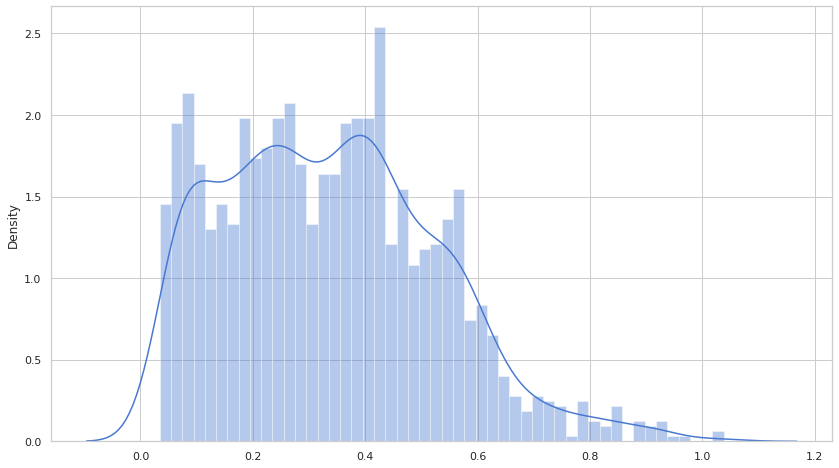

In [73]:
# distribution of the MAE loss for test data for LSTM AE
sns.distplot(test_mae_loss_AE, bins=50, kde=True);
## From the plot of Training MAE distribution we can say, all the dtapoints MAE lie within 0.0 to 0.6
# so, we can consider threshold error or MAE around 0.60 or greater, let us say 0.60 for this

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



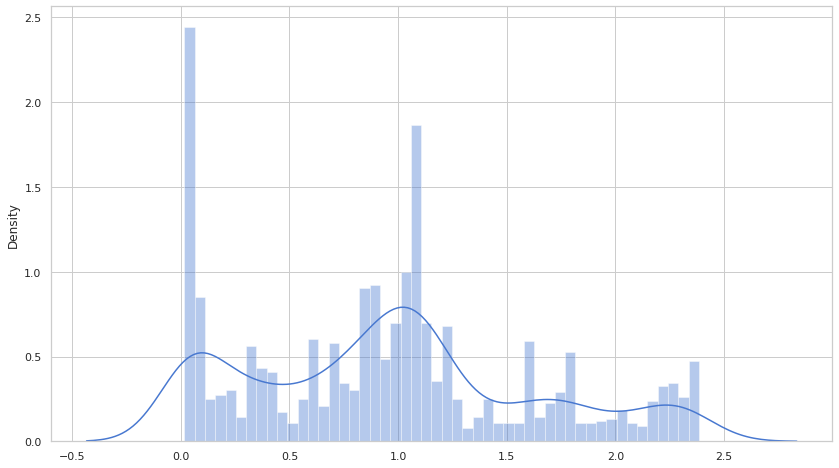

In [74]:
# distribution of the MAE loss for test data for LSTM
sns.distplot(test_mae_loss_LSTM, bins=50, kde=True);

## Task 8: Detect Anomalies in the S&P 500 Index Data using LSTM AE

In [75]:
# based on the MAE distribution we are keeping the threshold value as 0.65
THRESHOLD = 0.65

test_score_df = pd.DataFrame(test[time_steps:])
test_score_df['loss'] = test_mae_loss
test_score_df['threshold'] = THRESHOLD
test_score_df['anomaly'] = test_score_df.loss > test_score_df.threshold
test_score_df['close'] = test[time_steps:].close

In [44]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=test[time_steps:].date, y=test_score_df.loss,
                    mode='lines',
                    name='Test Loss'))
fig.add_trace(go.Scatter(x=test[time_steps:].date, y=test_score_df.threshold,
                    mode='lines',
                    name='Threshold'))
fig.update_layout(showlegend=True)
fig.show()

In [92]:
anomalies = test_score_df[test_score_df.anomaly == True]
anomalies

,date,close,loss,threshold,anomaly
7474,2015-08-25,2.457439,0.724154,0.6,True
7475,2015-08-26,2.632149,0.791537,0.6,True
7476,2015-08-27,2.745147,0.699877,0.6,True
7569,2016-01-11,2.591791,0.600070,0.6,True
7570,2016-01-12,2.627763,0.601439,0.6,True
...,...,...,...,...,...
8187,2018-06-25,4.493228,0.734083,0.6,True
8188,2018-06-26,4.507583,0.779650,0.6,True
8189,2018-06-27,4.451431,0.789795,0.6,True
8190,2018-06-28,4.491406,0.819372,0.6,True


In [46]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=test[time_steps:].date, y=scaler.inverse_transform(test[time_steps:].close),
                    mode='lines',
                    name='Close Price'))
fig.add_trace(go.Scatter(x=anomalies.date, y=scaler.inverse_transform(anomalies.close),
              # mode of the scatter plot is marker
                    mode='markers',
                    name='Anomaly'))
fig.update_layout(showlegend=True)
fig.show()

## Task 8: Detect Anomalies in the S&P 500 Index Data using LSTM

In [87]:
# based on the MAE distribution we are keeping the threshold value as 0.65
THRESHOLD = 0.60

test_score_df = pd.DataFrame(test[time_steps:])
test_score_df['loss'] = test_mae_loss
test_score_df['threshold'] = THRESHOLD
test_score_df['anomaly'] = test_score_df.loss > test_score_df.threshold
test_score_df['close'] = test[time_steps:].close

In [88]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=test[time_steps:].date, y=test_score_df.loss,
                    mode='lines',
                    name='Test Loss'))
fig.add_trace(go.Scatter(x=test[time_steps:].date, y=test_score_df.threshold,
                    mode='lines',
                    name='Threshold'))
fig.update_layout(showlegend=True)
fig.show()

In [91]:
anomalies = test_score_df[test_score_df.anomaly == True]
anomalies

,date,close,loss,threshold,anomaly
7474,2015-08-25,2.457439,0.724154,0.6,True
7475,2015-08-26,2.632149,0.791537,0.6,True
7476,2015-08-27,2.745147,0.699877,0.6,True
7569,2016-01-11,2.591791,0.600070,0.6,True
7570,2016-01-12,2.627763,0.601439,0.6,True
...,...,...,...,...,...
8187,2018-06-25,4.493228,0.734083,0.6,True
8188,2018-06-26,4.507583,0.779650,0.6,True
8189,2018-06-27,4.451431,0.789795,0.6,True
8190,2018-06-28,4.491406,0.819372,0.6,True


In [90]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=test[time_steps:].date, y=scaler.inverse_transform(test[time_steps:].close),
                    mode='lines',
                    name='Close Price'))
fig.add_trace(go.Scatter(x=anomalies.date, y=scaler.inverse_transform(anomalies.close),
              # mode of the scatter plot is marker
                    mode='markers',
                    name='Anomaly'))
fig.update_layout(showlegend=True)
fig.show()

**Thus we can detect anomalies usinfg both simple LSTM and LSTM Autoencoder enetwork, corresponds to datapoints where reconstruction error is higher that the threshold, which was determined based on the training MAE distribution**